In [72]:
import pandas as pd
import numpy as np 
from scipy.spatial import distance
import string
import tqdm
import spacy
import matplotlib.pyplot as plt

--------

### Get the embeddings

In [2]:
nlp = spacy.load('fr_core_news_sm')

def lemmatisation(text):
    doc = nlp(str(text))
    lemma = ''
    for token in doc:
        lemma += token.lemma_ + ' '
    return lemma

res = []
with open('../data/gdn_common_sorted.txt') as file : 
    for j, line in enumerate(file): 
        if j > 0 : 
            res.append(line.split(' ')[:701])
res = np.asarray(res)
embedding = pd.DataFrame(res[:,1:], index=res[:,0])
embeded_words = {}

for word in embedding.index : 
    embeded_words[word.split('_')[0]] = word
    
data = pd.read_csv('../data/dataset_1.csv')

# Let's lemmatise the dataset : WARNING, it takes about 11 min !!, take a break and drink some coffee ;-)
new_data = pd.DataFrame(np.copy(data), columns=data.columns)
for i in tqdm.tqdm(range(len(data))):
    new_data['solution'][i] = lemmatisation(new_data['solution'][i])
    
data = new_data

100%|██████████| 15309/15309 [10:41<00:00, 23.86it/s]


--------

### Compute variance and distance for argumentation

In [3]:
def preprocess(sentence): 
    '''
    return the sentence passed in argmuents with no punctuation
    '''
    sentence = sentence.replace('\'',' ').lower()
    table = sentence.maketrans('', '', string.punctuation)
    sentence = [w.translate(table) for w in sentence]
    sentence = ''.join(sentence)

    return sentence

In [73]:
def embed_answer(sentence): 
    sentence_embedding = []
    sentence = preprocess(sentence)
    words = sentence.split(' ')
    words = list(set(words))
    for i, word in enumerate(words):
        try : 
            if embeded_words[word].endswith('_n'):
                sentence_embedding.append(embedding.loc[embeded_words[word]].tolist())
        except KeyError: 
            continue
    
    return(np.asarray(sentence_embedding, dtype=np.float64))
   
def compute_score(sentence_embedding, eval_type='var'):
    # Could be interesting to add a cosine evaluation !
    # Or count the clusters which are concerned by the sentence.
    # (after clustering of the embeddings -> use a grid_search or dendrograms.)
    result = 0
    if eval_type == 'var':
        for index in range(len(sentence_embedding[0])):
            result += np.var(sentence_embedding[:,index])
            
    elif eval_type == 'dist':
        n = len(sentence_embedding)
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += np.linalg.norm(sentence_embedding[word_1_idx]-sentence_embedding[word_2_idx])
        result = result*2/(n*(n-1))
        
    elif eval_type == 'cos':
        n = len(sentence_embedding)
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += distance.cosine(sentence_embedding[word_1_idx],
                                          sentence_embedding[word_2_idx])
        result = result*2/(n*(n-1))

    return result

In [5]:
data.head(5)

,Unnamed: 0,zip_code,problem,solution
0,1,57000,Les problèmes auxquels se trouve confronté l’e...,le problème auxquel se trouve confronter l’ en...
1,5,95330,La pollution de l'air,en matière de émission de c02 tout n' être pas...
2,6,84750,La biodiversité et la disparition de certaines...,"arrêter le pesticide , notamment le glyphosate..."
3,10,33820,La pollution de l'air,- réduire de manière drastique le déplacement ...
4,14,8500,Pollution air et mers,interdir très rapidement le emballage plastiqu...


###### Quick look at the sentences and some results

In [6]:
n_print = 15
for i in range(n_print): 
    sentence = data.iloc[i]['solution']
    print(preprocess(sentence))
    print('Variance = ',compute_score(embed_answer(sentence),eval_type='var'))
    print('Distance = ',compute_score(embed_answer(sentence),eval_type='dist'))
    
    words = sentence.split(' ')
    words = list(set(words))
    embedded_words = []
    for i, word in enumerate(words):
        try : 
            if word in embeded_words.keys() and embeded_words[word].endswith('_n'):
                #embedding.loc[embeded_words[word]].tolist()
                embedded_words.append(word)
        except KeyError: 
            continue
    print('Embedded words : ', embedded_words)
    print('-'*100)

le problème auxquel se trouve confronter l’ ensemble de le planète et que dénoncer  dans le plus parfait désordre  le gilet jaune de france ne être  il pas dus  avant tout  à le surpopulation mondial  ce population être passer d’15 milliard d’ habitant en 1900 à 7 milliard en 2020 et monter bientôt à 10 milliard vers 2040    avec le progrès de le communication dans ce village mondial  chaque individu  de fin fond de l’ asie au fin fond de l’ afrique  en passer par le « quartiers » et le « campagne » de notre pays  aspir à vivre – et on ne peu l’ en blâmer – comme le moins mal lotir de notre concitoyen  logement  nourriture  bien de consommation  déplacement  etc      voilà le mère de tout le problème  si tel être bien le cas  le solution à tout le problème  stabilisation de le croissance démographique  partage un richesse  partage un terre  partage de l’ eau  protection de le biodiversité  règlement un conflit  lutte contre le déforestation  lutte contre dérèglement climatique  règleme

Variance =  11.838342103730058
Distance =  4.919837412501908
Embedded words :  ['citoyen', 'véhicule', 'hybride', 'exemple', 'écologie', 'doute', 'neuf', 'gouvernement', 'pas', 'environnement', 'bataille', 'contre', 'but', 'pollution', 'tout', 'lieu', 'un', 'voiture', 'bien', 'tel', 'prime', 'propre', 'effet', 'premier', 'ministre', 'cheval', 'montre', 'par', 'pourquoi', 'possibilité']
----------------------------------------------------------------------------------------------------
favoriser logistiquement et financièrement   le petit production local agricole  légume  fruit  viande  et son commercialisation pour éviter le transport inutile un produit vendre en grand surface  lequel ne penser que à leur profit  
Variance =  13.001864498174355
Distance =  5.2812125023511785
Embedded words :  ['local', 'son', 'légume', 'profit', 'un', 'production', 'petit', 'produit', 'fruit', 'surface', 'viande', 'commercialisation', 'transport']
------------------------------------------------------

--------

### Let's apply it to the whole dataset, we only focus on the solution proposed

In [7]:
scores = []
word_counter = []
freq = []

for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>1:
        scores.append([compute_score(answer, eval_type='var'),
                       compute_score(answer, eval_type='dist'),
                       compute_score(answer, eval_type='cos')])
    else:
        scores.append([np.nan, np.nan])
        
    sentence = preprocess(data.iloc[index]['solution'])
    words = sentence.split(' ')
    words = list(set(words))
    embedded_wds = []
    for i, word in enumerate(words):
        try : 
            if embeded_words[word].endswith('_n'):
                embedded_wds.append(word)
        except KeyError: 
            continue
    nb_words = len(embedded_wds)
    word_counter.append(nb_words)
    
unique_nb_words = np.unique(word_counter, return_counts=True)
nb_words_occ = {}
for nb_words, occ in zip(unique_nb_words[0],unique_nb_words[1]):
    nb_words_occ[nb_words] = occ
    
for nb_words in word_counter:
    freq.append(nb_words_occ[nb_words])
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns=['Variance', 'Distance', 'Cosine'])
word_counter_df = pd.DataFrame(data=np.array(word_counter),index=data.index, columns=['Nb_words'])
freq_df = pd.DataFrame(data=np.array(freq),index=data.index, columns=['Freq'])
argumentation_scores = pd.concat([data['zip_code'], scores_df, word_counter_df, freq_df], axis=1)
argumentation_scores.head(5)

100%|██████████| 15309/15309 [14:07<00:00, 18.06it/s]


,zip_code,Variance,Distance,Nb_words,Freq
0,57000,13.492236,5.200961,60,34
1,95330,12.614204,5.007380,77,17
2,84750,12.805894,5.116135,26,276
3,33820,13.407533,5.260951,25,334
4,8500,12.127912,4.992264,17,596


In [74]:
scores = []

for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>1:
        scores.append([compute_score(answer, eval_type='cos')])
    else:
        scores.append([np.nan, np.nan])
        
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns=['Cosine'])
argumentation_scores = pd.concat([argumentation_scores, scores_df], axis=1)
argumentation_scores.head(5)

100%|██████████| 15309/15309 [19:15<00:00, 13.25it/s]  


,zip_code,Variance,Distance,Nb_words,Freq,Cosine
0,57000,13.492236,5.200961,60,34,0.862055
1,95330,12.614204,5.007380,77,17,0.849357
2,84750,12.805894,5.116135,26,276,0.849809
3,33820,13.407533,5.260951,25,334,0.802591
4,8500,12.127912,4.992264,17,596,0.809353


--------

### Have a look at extreme values

In [8]:
values = argumentation_scores['Variance'].dropna().values
interesting_data = data.drop(argumentation_scores['Variance'].index[argumentation_scores['Variance'].apply(np.isnan)])
percentile = np.percentile(abs(values),99) # A tester avec 1 et < dans la ligne au dessous
interesting_values = values[abs(values)>percentile]
interesting_sentences = interesting_data[abs(values)<percentile]['solution']
for index in range(len(interesting_values)):
    sentence = preprocess(interesting_sentences.iloc[index])
    print(sentence)
    print('Variance = ', interesting_values[index])
    embedded_words = []
    for i, word in enumerate(sentence.split(' ')):
        try : 
            if word in embeded_words.keys() and embeded_words[word].endswith('_n'):
                #embedding.loc[embeded_words[word]].tolist()
                embedded_words.append(word)
        except KeyError: 
            continue
    print('Embedded words : ', embedded_words)
    print('-'*100)

le problème auxquel se trouve confronter l’ ensemble de le planète et que dénoncer  dans le plus parfait désordre  le gilet jaune de france ne être  il pas dus  avant tout  à le surpopulation mondial  ce population être passer d’15 milliard d’ habitant en 1900 à 7 milliard en 2020 et monter bientôt à 10 milliard vers 2040    avec le progrès de le communication dans ce village mondial  chaque individu  de fin fond de l’ asie au fin fond de l’ afrique  en passer par le « quartiers » et le « campagne » de notre pays  aspir à vivre – et on ne peu l’ en blâmer – comme le moins mal lotir de notre concitoyen  logement  nourriture  bien de consommation  déplacement  etc      voilà le mère de tout le problème  si tel être bien le cas  le solution à tout le problème  stabilisation de le croissance démographique  partage un richesse  partage un terre  partage de l’ eau  protection de le biodiversité  règlement un conflit  lutte contre le déforestation  lutte contre dérèglement climatique  règleme

interdire le usine à charbon dans tout le europe  faute de quoi un astreinte financier de pays concerné dans un banque de le transition écologique à créer  trouver un accord européen pour tout le compagnie aérien survoler le espace aérien européen pour taxer le kérosène  idem pour le fuel lourd un bateau cargo et bateal de croisière circuler dans notre espace maritime européen  le idée de taxer le poids lourd étranger circuler sur notre réseau routier devoir aboutir  pénaliser le entreprise ne faire pas le effort climatique  financer et accompagner davantage le recherche un bio carburant  le voiture à hydrogène  le bio diésel  le voiture à le eau  lutter contre le lobby avec plus de ténacité dans ce domaine  
Variance =  14.922347995159553
Embedded words :  ['usine', 'charbon', 'tout', 'faute', 'un', 'astreinte', 'financier', 'pays', 'un', 'banque', 'transition', 'un', 'accord', 'européen', 'tout', 'compagnie', 'espace', 'européen', 'kérosène', 'fuel', 'un', 'bateau', 'cargo', 'croisiè

--------

### Normalisation of the values

In [98]:
with_counter = pd.concat([argumentation_scores, pd.DataFrame(np.array(word_counter))], axis=1)

# Then, let's compute the mean and variance values of the variances (resp. distance) 
# with respect to the number of words.
normalized_scores = pd.DataFrame(np.copy(argumentation_scores), columns=argumentation_scores.columns)

unique_word_nb = np.unique(word_counter, return_counts=True)
for word_nb, freq in tqdm.tqdm(zip(unique_word_nb[0],unique_word_nb[1])):
    for eval_type in ['Variance', 'Distance', 'Cosine']:
        if freq>1:
            corresponding_values=[]
            indexes=[]
            for idx in np.where(np.array(word_counter)==word_nb)[0]:
                if not np.isnan(argumentation_scores.iloc[idx][eval_type]): 
                    # If only one word or less is embedded, then the variance and distance value are nan
                    # and we mustn't consider them in the normalisation...
                    corresponding_values.append(argumentation_scores.iloc[idx][eval_type])
                    indexes.append(idx)

            mean_value = np.mean(corresponding_values)
            var_value = np.var(corresponding_values)

            for idx in indexes:
                normalized_scores.iloc[idx][eval_type] -= mean_value
                normalized_scores.iloc[idx][eval_type] /= var_value
                
normalized_scores.columns = ['zip_code','Variance_word_std','Distance_word_std', 
                             'Cosine_word_std','Nb_words','Freq']

normalized_scores = pd.concat([argumentation_scores['Variance'], 
                               argumentation_scores['Distance'],
                               argumentation_scores['Cosine'], normalized_scores], axis=1)

168it [00:46, 70.91it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
221it [00:46,  4.73it/s]


### Add the department according to each zip_code

In [99]:
department = np.copy(normalized_scores['zip_code'].values)
for dpt_idx in range(len(department)):
    if department[dpt_idx]>=1 and department[dpt_idx]<=95:
        continue
    elif department[dpt_idx]>=1000 and department[dpt_idx]<96000:
        department[dpt_idx] = int(department[dpt_idx]/1000)

department_df = pd.DataFrame(department, columns=['Department'])

final_data = pd.concat([department_df, normalized_scores], axis=1)
final_data = final_data.dropna()
final_data['Freq'] = final_data['Freq'].astype(int)
final_data['Nb_words'] = final_data['Nb_words'].astype(int)
final_data['zip_code'] = final_data['zip_code'].astype(int)
final_data['Department'] = final_data['Department'].astype(int)
final_data = final_data[final_data['Department']>=1]
final_data = final_data[final_data['Department']<=95]

print(final_data.shape)
final_data.head()

(15128, 10)


,Department,Variance,Distance,Cosine,zip_code,Variance_word_std,Distance_word_std,Cosine_word_std,Nb_words,Freq
0,57,13.492236,5.200961,0.862055,57000,0.367687,1.97516,60,34,77
1,95,12.614204,5.007380,0.849357,95330,-2.40945,-12.8462,77,17,-146
2,84,12.805894,5.116135,0.849809,84750,0.136498,0.537683,26,276,19
3,33,13.407533,5.260951,0.802591,33820,0.792396,4.09159,25,334,-108
4,8,12.127912,4.992264,0.809353,8500,-0.33539,-2.46286,17,596,-52


--------

### Let's plot the histograms Occ=f(Var) and Occ=f(Dist) for the most represented departments

75 -0.07933896090299718 0.8991065850587342
69 0.005394653296386645 0.9514734394115464
31 -0.05570150820639899 0.9620351972801995
13 -0.01985721051631088 0.9056849963555753
92 -0.016182227140531955 0.9345394022515912


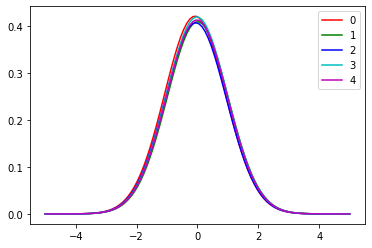

In [100]:
# Let's plot the hist for the most represented department
colors = ['r','g','b','c','m']
unique_dpt = np.unique(final_data['Department'], return_counts=True)
dpts = unique_dpt[0]
counts = unique_dpt[1]
for k in range(5):
    max_dpt_idx = np.argmax(counts)
    max_dpt = dpts[max_dpt_idx]

    values = final_data[final_data['Department']==max_dpt]['Variance_word_std'].dropna().values
    percentile = np.percentile(abs(values),95)
    valid_values = values[abs(values)<percentile]
    
    M = np.mean(valid_values)
    V = np.var(valid_values)
    print(max_dpt,M,V)
    gauss_pdf = lambda x,V,M: 1/np.sqrt(2*np.pi*V) * np.exp(-.5*(x-M)**2)
    X = np.linspace(-5,5,100)
    Y = []
    for elt in X:
        Y.append(gauss_pdf(elt,V,M))

    #final_data[final_data['Department']==max_dpt]['Variance_std'].hist(bins=2000, alpha=0.5)
    plt.plot(X,Y,color=colors[k%5],label=k)
    #plt.xlim(right=-5, left=5)
    #plt.ylim(bottom=0, top=2)
    counts = np.delete(counts,max_dpt_idx)
    dpts = np.delete(dpts,max_dpt_idx)
plt.legend()
plt.show()

--------

### Let's add the values to the dataframe

In [101]:
unique_dpt = np.unique(final_data['Department'], return_counts=True)[0]
mapping = {'Variance':{},'Distance':{},'Cosine':{},
           'Variance_word_std':{},'Distance_word_std':{},'Cosine_word_std':{}}

for eval_type in mapping.keys():
    for dpt in unique_dpt:
        values = final_data[final_data['Department']==dpt][eval_type].dropna().values
        try:
            percentile = np.percentile(abs(values),95)
            valid_values = values[abs(values)<=percentile]

            M = np.mean(valid_values)
            V = np.var(valid_values)
        except:
            M, V = np.nan, np.nan

        mapping[eval_type][dpt] = [M,V]
    
    
    # May need to add this to the dataframe... Then, uncomment the code below
    #try:
    #    final_data = final_data.drop(eval_type + '_mean_wrt_dpt', axis=1)
    #except:
    #    pass
    #means = []
    #for index in final_data.index:
    #    means.append(mapping[eval_type][final_data['Department'][index]][0])

    #means = pd.DataFrame(means, index=final_data.index, columns=[eval_type + '_mean_wrt_dpt'])
    #final_data = pd.concat([final_data, means], axis=1)

--------

### Plot the cartographie of the scores

In [102]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
pd.options.mode.chained_assignment = None  # default='warn'

def plot_cartography(Colors, eval_type, figsize=(10, 6)):
    # set the filepath and load in a shapefile
    fp = '../data/departements-20180101-shp/departements-20180101.shp'
    map_df = gpd.read_file(fp)
    # check data type so we can see that this is not a normal dataframe, but a GEOdataframe
    merged = pd.concat([map_df.set_index('code_insee').join(Colors.set_index('code_insee'))], axis=1)
    merged['colors']['2A'] = merged['colors']['2B'] = Colors['colors'][20]
    merged['colors']['69D'] = merged['colors']['69M'] = Colors['colors'][69]
    for idx in merged.index:
        if idx not in Colors['code_insee'].values and idx!='2A' and idx!='2B' and idx!='69D' and idx!='69M':
            merged = merged.drop(index=idx)
    merged.head()

    # set a variable that will call whatever column we want to visualise on the map
    variable = 'colors'
    # set the range for the choropleth
    vmin, vmax = np.min(merged[variable].values), np.max(merged[variable].values)
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=figsize)

    # create map
    merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

    ax.axis('off')

    ax.set_title("French Departments, colors correpond to the mean of the argumentation scores : " + eval_type,
                 fontdict={'fontsize': '10', 'fontweight' : '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)

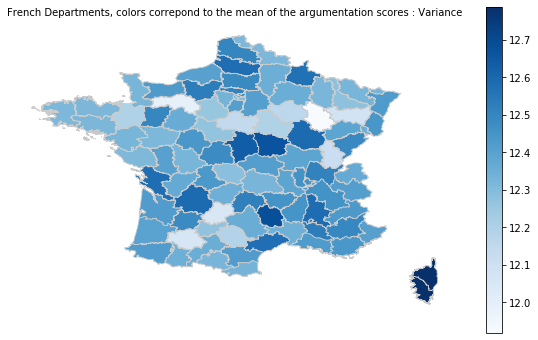

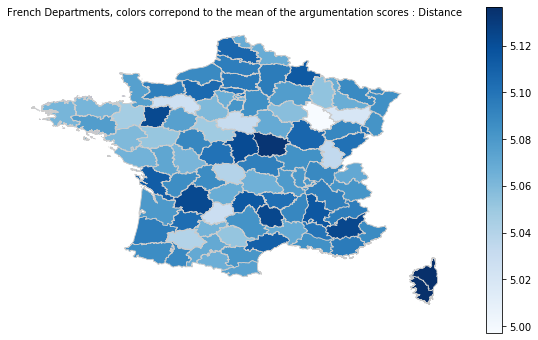

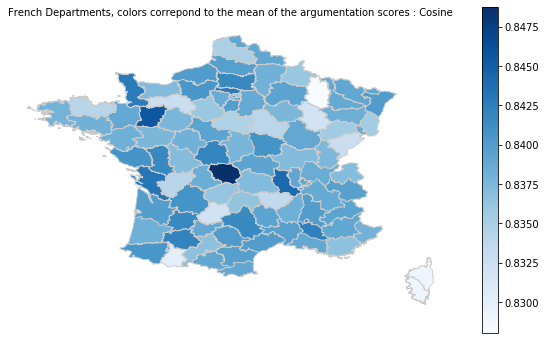

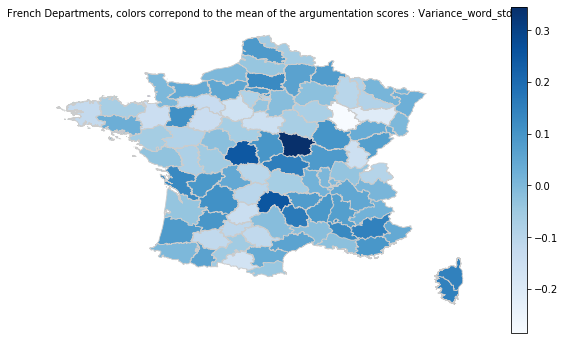

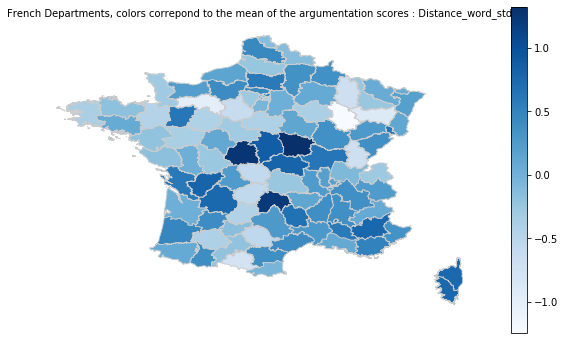

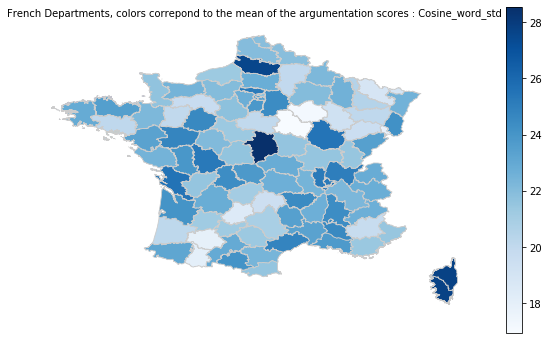

In [104]:
dpts = [k for k in range(1,96)]
for eval_type in ['Variance','Distance','Cosine',
                  'Variance_word_std','Distance_word_std','Cosine_word_std']:
    Colors = []
    for dpt in dpts:
        Colors.append(mapping[eval_type][dpt][0]) # Because in the geopandas the departments go from 0 to 94

    Colors = pd.DataFrame(Colors, index=dpts, columns=['colors'])
    Colors = pd.concat([Colors, pd.DataFrame(['0'+str(k) for k in range(1,10)] + [str(k) for k in range(10,96)],
                                             index=dpts, columns=['code_insee'])], axis=1)

    plot_cartography(Colors, eval_type, figsize=(10,6))
    plt.savefig('../../{}.png'.format(eval_type))